# 0. Depdencies & Imports

In [1]:
!pip install torch torchvision torchviz matplotlib numpy tqdm scikit-image tensorboard_logger

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions import Normal
from torch.utils.data import Dataset
from torchviz import make_dot

import skimage.measure

import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np


import unittest
import time
import shutil
import os
import math

import pickle

from tqdm.notebook import tqdm

from enum import Enum

# 1. Configuration

In [3]:
class DatasetName(Enum):
    MNIST = 1
    AUGMENTED = 2
    TRANSFORMED = 3
    AUGMENTED_MEDICAL = 4
    AUGMENTED_MEDICAL_3 = 5
    AUGMENTED_MEDICAL_SIMPLE = 6
    AUGMENTED_MEDICAL_SIMPLE_2 = 7

In [4]:
class Config():
    def __init__(self):
        # glimpse network params
        self.patch_size      = 16         # size of extracted patch at highest res
        self.glimpse_scale   = 2         # scale of successive patches
        self.num_patches     = 5         # Num of downscaled patches per glimpse
        self.loc_hidden      = 128       # hidden size of loc fc layer
        self.glimpse_hidden  = 128       # hidden size of glimpse fc

        # core network params
        self.num_glimpses    = 8         # Num of glimpses, i.e. BPTT iterations
        self.hidden_size     = 256       # hidden size of rnn

        # reinforce params
        self.std             = 0.05      # gaussian policy standard deviation
        self.M               = 1         # Monte Carlo sampling for valid and test sets

        # ETC params
        self.valid_size      = 0.1       # Proportion of training set used for validation
        self.batch_size      = 128       # Num of images in each batch of data
        self.num_workers     = 4         # Num of subprocesses to use for data loading
        self.shuffle         = True      # Whether to shuffle the train and valid indices
        self.show_sample     = False     # Whether to visualize a sample grid of the data

        # training params
        self.is_train        = True      # Whether to train(true) or test the model
        self.momentum        = 0.5       # Nesterov momentum value
        self.epochs          = 500        # Num of epochs to train for
        self.init_lr         = 3e-4      # Initial learning rate value
        self.lr_patience     = 20        # Number of epochs to wait before reducing lr
        self.train_patience  = 50        # Number of epochs to wait before stopping train

        # other params
        self.use_gpu         = True      # Whether to run on the GPU
        self.best            = True      # Load best model or most recent for testing
        self.random_seed     = 1         # Seed to ensure reproducibility
        self.data_dir        = "./data"  # Directory in which data is stored
        self.ckpt_dir        = "./ckpt"  # Directory in which to save model checkpoints
        self.logs_dir        = "./logs/" # Directory in which Tensorboard logs wil be stored
        self.use_tensorboard = False     # Whether to use tensorboard for visualization
        self.resume          = False     # Whether to resume training from checkpoint
        self.print_freq      = 100        # How frequently to print training details
        self.plot_freq       = 1         # How frequently to plot glimpses
        self.dataset         = DatasetName.AUGMENTED_MEDICAL_SIMPLE_2
        self.model_name      = "ram_{}_{}x{}_{}".format(
            self.num_glimpses,
            self.patch_size,
            self.patch_size,
            self.glimpse_scale,
        )

In [5]:
global_config = Config()

In [6]:
#set seed for reproducibility
torch.manual_seed(global_config.random_seed)
np.random.seed(global_config.random_seed)

# 2. Datasets

In [7]:
class AugmentedMedicalMNISTDataset(Dataset):
    """
    Augmented mnist meant to mimic whole-slide-images of tumor cells.
    9's represent cancer cells. There are 4 different labels, based on the number of 9's:
    
    zero 9's          - no cancer
    one 9             - isolated tumor cell
    two 9's           - micro-metastasis 
    three or more 9's - macro-metastasis
    
    Each image contains between 3 and 10 cells at random, which may be overlapping.
    It consists of 5000 items of each category(total 20.000) for training and 500(2.000) of each for testing
    of size 256 x 256. 
    """

    def __init__(self, 
                 root_dir,
                 train,
                 data_dir = "MEDNIST",
                 mnist_transform = None,
                 transform = None, 
                 total_train = 20000,
                 total_test = 2000,
                 n_partitions_test = 1,
                 n_partitions_train = 5):
        
        self.mnist_transform = mnist_transform
        self.root_dir = root_dir
        self.train = train
        self.total = total_train if self.train else total_test
        self.n_partitions_test  = n_partitions_test
        self.n_partitions_train = n_partitions_train
        self.dir = os.path.join(root_dir,data_dir, "train" if train else "test")
        self.transform = transform
        
        self.__create_dataset_if_needed()
                
        self.__load_data()
        
    def __dataset_exists(self):
        # mkdir if not exists
        os.makedirs(self.dir, exist_ok = True)
        len_files = len(os.listdir(self.dir)) 
        if len_files > 0:
            print("Data existing, skipping creation.")
            return True
        else:
            print("Dataset missing. Creating...")
        return False
            
    
    def __combine_images(self,images, output_dim):
        """
        Combines the given images into a single image of output_dim size. Combinations are done randomly and 
        overlapping is possible. Images will always be within bounds completely.
        """
        np_images = np.array(images)
        input_dim = np_images.shape[-1]
        new_image = np.zeros(shape=(output_dim,output_dim), dtype = np.float32)
        for image in np_images:
            i, j = np.random.randint(0, output_dim  - input_dim, size = 2)
            new_image[i:i+input_dim, j:j+input_dim] = image
        return new_image
    
    def __get_cell_counts(self, items_per_class_count, class_index):
        # exclusive
        max_items = 11
        min_number_of_cells = 3
        # 0,1,2,3+ for no tumor cells, isolated tumor cells, 
        # micro-metastasis and macro-metastasis respectively
        num_tumor_cells = class_index if class_index != 3 else np.random.randint(3, max_items) 

        num_healthy_cells = max_items - num_tumor_cells
        if num_healthy_cells + num_tumor_cells < min_number_of_cells:
            num_healthy_cells = min_number_of_cells - num_tumor_cells

        return (num_tumor_cells, num_healthy_cells)
            
    def __generate_for_class(self,
                                   items,
                                   items_per_class_count,
                                   class_index,
                                   uid,
                                   all_tumor_cell_images,
                                   all_healthy_cell_images):
        for _ in range(items_per_class_count):
            num_tumors, num_healthy = self.__get_cell_counts(items_per_class_count, class_index)

            healthy_idxs = np.random.randint(0,len(all_healthy_cell_images), num_healthy)
            tumor_idxs   = np.random.randint(0,len(all_tumor_cell_images), num_tumors)

            cells = np.vstack((all_healthy_cell_images[healthy_idxs], all_tumor_cell_images[tumor_idxs]))
            image = self.__combine_images(cells, 256)
            image = np.expand_dims(image, axis = 0)
            self.data.append(image)
            self.labels.append(class_index)
            uid += 1
        return uid
            
    def __create_dataset_if_needed(self):
        if self.__dataset_exists():
            return 
        
        self.data = []
        self.labels = []
        
        # in how many partitions to split dataset creation
        partitions_count = 10
        
        # number of classes in output (fixed)
        num_classes = 4
        
        mnist = torchvision.datasets.MNIST(root ='./data',
                                           train = self.train,
                                           download = True,
                                           transform = self.mnist_transform)
        
        mnist_loader = iter(torch.utils.data.DataLoader(mnist, 
                                                        batch_size = int(self.total/partitions_count), 
                                                        shuffle = False, 
                                                        num_workers = 0))
        uid = 0
        batch, mnist_labels = mnist_loader.next()
        for _ in range(partitions_count):
            # 9's represent tumors
            all_tumor_cell_images = batch[mnist_labels == 9]
            # everything else except 6's healthy cells
            all_healthy_cell_images = batch[(mnist_labels != 9) & (mnist_labels != 6)]
            
            items_per_class_count = int(self.total/(num_classes * partitions_count))
            
            for class_index in range(num_classes):
                    uid = self.__generate_for_class(class_index, 
                                                  items_per_class_count,
                                                  class_index,
                                                  uid,
                                                  all_tumor_cell_images,
                                                  all_healthy_cell_images)
        self.__store()
        print("Done.")
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, uid):
        if torch.is_tensor(uid):
            uid = uid.tolist()
        label = self.labels[uid]
        sample = self.data[uid]
        if self.transform:
            sample = self.transform(sample)

        return (sample,label)

    def __store(self):
        n_partitions = self.n_partitions_train if self.train else self.n_partitions_test
        
        assert(len(self.data) == len(self.labels))
        max_index = len(self.data)
        partition_size = max_index/n_partitions
        for i in range(n_partitions):
            start,end =(int(partition_size * i), int(partition_size * (i+1)))
            partition = np.array(self.data[start:end])
            np.save(os.path.join(self.dir, "part_" + str(i)), partition)
        
        np.save(os.path.join(self.dir, "labels"), np.array(self.labels))
    
    def __load_data(self):
        n_partitions = self.n_partitions_train if self.train else self.n_partitions_test
        data = []
        for i in range(n_partitions):
            data.append(np.load(os.path.join(self.dir, "part_" + str(i)+".npy")))
        self.data = np.vstack(data)
        self.labels = np.load(os.path.join(self.dir, "labels.npy"))

In [8]:
class DatasetType(Enum):
    TRAIN = 1
    VALID = 2
    TEST  = 3
    
class DatasetLocator():
    def __init__(self, conf: Config):
        
        self.dataset = conf.dataset
        self.gpu_run = conf.use_gpu
        self.batch_size = conf.batch_size
        train, valid, test = self.__load_data()
        
        self.dataset_dict = {
            DatasetType.TRAIN: train,
            DatasetType.VALID: valid,
            DatasetType.TEST: test
        }
        
    def __f(self,image):
        np_image = np.array(image)
        input_dim = np_image.shape[-1]
        new_image = np.zeros(shape=(60,60), dtype = np.float32)
        i, j = np.random.randint(0, 60  - input_dim, size = 2)
        new_image[i:i+input_dim, j:j+input_dim] = np_image
        return new_image
    
    def __transformed_mnist_transformation(self):
        return transforms.Compose(
            [torchvision.transforms.Lambda(self.__f),
            torchvision.transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

    def __augmented_mnist_transformation(self):
        return transforms.Compose([
            torchvision.transforms.RandomAffine(degrees = (-180,180),scale = (0.5,1.0),),
            torchvision.transforms.ToTensor()])
    
    def __augmented_mnist_simple_transformation(self):
        return transforms.Compose([
            torchvision.transforms.RandomAffine(degrees = (0,90),scale = (0.9,1.0),),
            torchvision.transforms.ToTensor()])

    def __load_data(self):
        train_total = self.__load_dataset(True)
        test = self.__load_dataset(False)
        
        train_length = int(len(train_total) * 0.9)
        valid_length = len(train_total) - train_length
        (train, valid) = torch.utils.data.random_split(train_total,(train_length, valid_length))
        return (train, valid, test)
    
    def __load_dataset(self, is_train):
        if self.dataset == DatasetName.MNIST:
            transform = torchvision.transforms.ToTensor()
        elif self.dataset == DatasetName.AUGMENTED:
            transform = self.__augmented_mnist_transformation()
        elif self.dataset == DatasetName.TRANSFORMED:
            transform = self.__transformed_mnist_transformation()
        elif self.dataset == DatasetName.AUGMENTED_MEDICAL:
            return AugmentedMedicalMNISTDataset(root_dir='.', data_dir = "MEDNIST",train = is_train, mnist_transform = self.__augmented_mnist_transformation())
        elif self.dataset == DatasetName.AUGMENTED_MEDICAL_3:
            return AugmentedMedicalMNISTDataset(root_dir='.',total_train = 60000, n_partitions_train = 15, data_dir = "MEDNIST_3", train = is_train, mnist_transform = self.__augmented_mnist_transformation())
        elif self.dataset == DatasetName.AUGMENTED_MEDICAL_SIMPLE:
            return AugmentedMedicalMNISTDataset(root_dir='.',data_dir = "MEDNIST_SIMPLE", train = is_train, mnist_transform = self.__augmented_mnist_simple_transformation())
        elif self.dataset == DatasetName.AUGMENTED_MEDICAL_SIMPLE_2:
            return AugmentedMedicalMNISTDataset(root_dir='.',data_dir = "MEDNIST_SIMPLE_2", train = is_train, mnist_transform = self.__augmented_mnist_simple_transformation())
        return torchvision.datasets.MNIST(root='./data', train = is_train , download = True, transform = transform)
        
    def data_loader(self, dataset:DatasetType):
        should_shuffle = dataset == DatasetType.TRAIN
        data = self.dataset_dict[dataset] 
        return torch.utils.data.DataLoader(data,
                                           batch_size = self.batch_size,
                                           pin_memory = self.gpu_run,
                                           shuffle = should_shuffle,
                                           num_workers = 0)
    

In [9]:
global_config = Config()

In [10]:
locator = DatasetLocator(global_config)

Data existing, skipping creation.
Data existing, skipping creation.


In [11]:
images,labels = iter(locator.data_loader(DatasetType.TRAIN)).next()
images = images[0:4]
labels = labels[0:4]

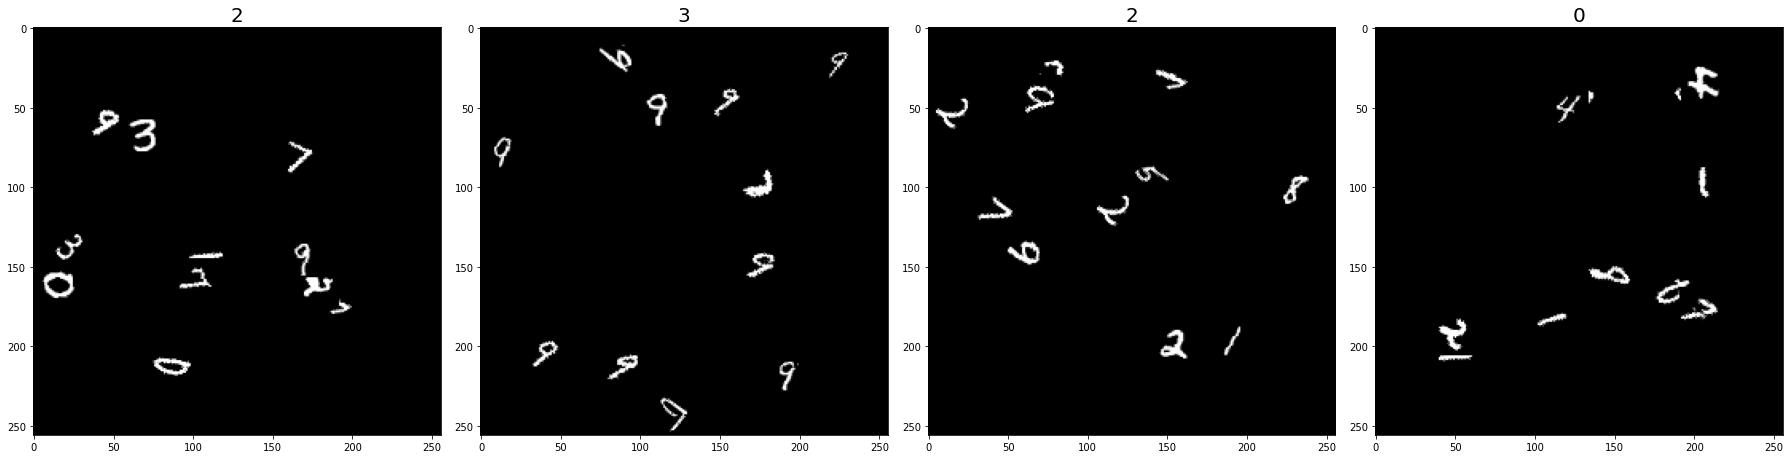

In [12]:
def show(images,labels = None):
    if labels == None:
        labels = [" "] * len(images)
    elif isinstance(labels,torch.Tensor): 
        labels = [label.item() for label in labels]
    fig, axes = plt.subplots(1, len(images), figsize=(25,25))
    for (a,image,label) in zip(axes.ravel(),images,labels):
        a.imshow(image[0].numpy(), cmap = plt.cm.gray)
        a.set_title(label, fontsize=20)

    fig.tight_layout()
show(images,labels)

# Utils

In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image


def denormalize(T, coords):
    return 0.5 * ((coords + 1.0) * T)


def bounding_box(x, y, size, color="w"):
    x = int(x - (size / 2))
    y = int(y - (size / 2))
    rect = patches.Rectangle(
        (x, y), size, size, linewidth=1, edgecolor=color, fill=False
    )
    return rect


# https://github.com/pytorch/examples/blob/master/imagenet/main.py
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def resize_array(x, size):
    # 3D and 4D tensors allowed only
    assert x.ndim in [3, 4], "Only 3D and 4D Tensors allowed!"

    # 4D Tensor
    if x.ndim == 4:
        res = []
        for i in range(x.shape[0]):
            img = array2img(x[i])
            img = img.resize((size, size))
            img = np.asarray(img, dtype="float32")
            img = np.expand_dims(img, axis=0)
            img /= 255.0
            res.append(img)
        res = np.concatenate(res)
        res = np.expand_dims(res, axis=1)
        return res

    # 3D Tensor
    img = array2img(x)
    img = img.resize((size, size))
    res = np.asarray(img, dtype="float32")
    res = np.expand_dims(res, axis=0)
    res /= 255.0
    return res


def img2array(data_path, desired_size=None, expand=False, view=False):
    """
    Util function for loading RGB image into a numpy array.

    Returns array of shape (1, H, W, C).
    """
    img = Image.open(data_path)
    img = img.convert("RGB")
    if desired_size:
        img = img.resize((desired_size[1], desired_size[0]))
    if view:
        img.show()
    x = np.asarray(img, dtype="float32")
    if expand:
        x = np.expand_dims(x, axis=0)
    x /= 255.0
    return x


def array2img(x):
    """
    Util function for converting anumpy array to a PIL img.

    Returns PIL RGB img.
    """
    x = np.asarray(x)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    return Image.fromarray(x.astype("uint8"), "RGB")


def plot_images(images, gd_truth):

    images = images.squeeze()
    assert len(images) == len(gd_truth) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot the image
        ax.imshow(images[i], cmap="Greys_r")

        xlabel = "{}".format(gd_truth[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


def prepare_dirs(config):
    for path in [config.data_dir, config.ckpt_dir, config.logs_dir]:
        if not os.path.exists(path):
            os.makedirs(path)


def save_config(config):
    model_name = "ram_{}_{}x{}_{}".format(
        config.num_glimpses, config.patch_size, config.patch_size, config.glimpse_scale
    )
    filename = model_name + "_params.json"
    param_path = os.path.join(config.ckpt_dir, filename)

    print("[*] Model Checkpoint Dir: {}".format(config.ckpt_dir))
    print("[*] Param Path: {}".format(param_path))

    with open(param_path, "w") as fp:
        json.dump(config.__dict__, fp, indent=4, sort_keys=True)

# 3. Network

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions import Normal


class Retina:
    """A visual retina.

    Extracts a foveated glimpse `phi` around location `l`
    from an image `x`.

    Concretely, encodes the region around `l` at a
    high-resolution but uses a progressively lower
    resolution for pixels further from `l`, resulting
    in a compressed representation of the original
    image `x`.

    Args:
        x: a 4D Tensor of shape (B, H, W, C). The minibatch
            of images.
        l: a 2D Tensor of shape (B, 2). Contains normalized
            coordinates in the range [-1, 1].
        g: size of the first square patch.
        k: number of patches to extract in the glimpse.
        s: scaling factor that controls the size of
            successive patches.

    Returns:
        phi: a 5D tensor of shape (B, k, g, g, C). The
            foveated glimpse of the image.
    """

    def __init__(self, g, k, s):
        self.g = g
        self.k = k
        self.s = s

    def foveate(self, x, l):
        """Extract `k` square patches of size `g`, centered
        at location `l`. The initial patch is a square of
        size `g`, and each subsequent patch is a square
        whose side is `s` times the size of the previous
        patch.

        The `k` patches are finally resized to (g, g) and
        concatenated into a tensor of shape (B, k, g, g, C).
        """
        phi = []
        size = self.g

        # extract k patches of increasing size
        for i in range(self.k):
            phi.append(self.extract_patch(x, l, size))
            size = int(self.s * size)

        # resize the patches to squares of size g
        for i in range(1, len(phi)):
            k = phi[i].shape[-1] // self.g
            phi[i] = F.avg_pool2d(phi[i], k)

        # concatenate into a single tensor and flatten
        phi = torch.cat(phi, 1)
        phi = phi.view(phi.shape[0], -1)

        return phi

    def extract_patch(self, x, l, size):
        """Extract a single patch for each image in `x`.

        Args:
        x: a 4D Tensor of shape (B, H, W, C). The minibatch
            of images.
        l: a 2D Tensor of shape (B, 2).
        size: a scalar defining the size of the extracted patch.

        Returns:
            patch: a 4D Tensor of shape (B, size, size, C)
        """
        B, C, H, W = x.shape

        start = self.denormalize(H, l)
        end = start + size

        # pad with zeros
        x = F.pad(x, (size // 2, size // 2, size // 2, size // 2))

        # loop through mini-batch and extract patches
        patch = []
        for i in range(B):
            patch.append(x[i, :, start[i, 1] : end[i, 1], start[i, 0] : end[i, 0]])
        return torch.stack(patch)

    def denormalize(self, T, coords):
        """Convert coordinates in the range [-1, 1] to
        coordinates in the range [0, T] where `T` is
        the size of the image.
        """
        return (0.5 * ((coords + 1.0) * T)).long()

    def exceeds(self, from_x, to_x, from_y, to_y, T):
        """Check whether the extracted patch will exceed
        the boundaries of the image of size `T`.
        """
        if (from_x < 0) or (from_y < 0) or (to_x > T) or (to_y > T):
            return True
        return False


class GlimpseNetwork(nn.Module):
    """The glimpse network.

    Combines the "what" and the "where" into a glimpse
    feature vector `g_t`.

    - "what": glimpse extracted from the retina.
    - "where": location tuple where glimpse was extracted.

    Concretely, feeds the output of the retina `phi` to
    a fc layer and the glimpse location vector `l_t_prev`
    to a fc layer. Finally, these outputs are fed each
    through a fc layer and their sum is rectified.

    In other words:

        `g_t = relu( fc( fc(l) ) + fc( fc(phi) ) )`

    Args:
        h_g: hidden layer size of the fc layer for `phi`.
        h_l: hidden layer size of the fc layer for `l`.
        g: size of the square patches in the glimpses extracted
        by the retina.
        k: number of patches to extract per glimpse.
        s: scaling factor that controls the size of successive patches.
        c: number of channels in each image.
        x: a 4D Tensor of shape (B, H, W, C). The minibatch
            of images.
        l_t_prev: a 2D tensor of shape (B, 2). Contains the glimpse
            coordinates [x, y] for the previous timestep `t-1`.

    Returns:
        g_t: a 2D tensor of shape (B, hidden_size).
            The glimpse representation returned by
            the glimpse network for the current
            timestep `t`.
    """

    def __init__(self, h_g, h_l, g, k, s, c):
        super().__init__()

        self.retina = Retina(g, k, s)

        # glimpse layer
        D_in = k * g * g * c
        self.fc1 = nn.Linear(D_in, h_g)

        # location layer
        D_in = 2
        self.fc2 = nn.Linear(D_in, h_l)

        self.fc3 = nn.Linear(h_g, h_g + h_l)
        self.fc4 = nn.Linear(h_l, h_g + h_l)

    def forward(self, x, l_t_prev):
        # generate glimpse phi from image x
        phi = self.retina.foveate(x, l_t_prev)

        # flatten location vector
        l_t_prev = l_t_prev.view(l_t_prev.size(0), -1)

        # feed phi and l to respective fc layers
        phi_out = F.relu(self.fc1(phi))
        l_out = F.relu(self.fc2(l_t_prev))

        what = self.fc3(phi_out)
        where = self.fc4(l_out)

        # feed to fc layer
        g_t = F.relu(what + where)

        return g_t


class CoreNetwork(nn.Module):
    """The core network.

    An RNN that maintains an internal state by integrating
    information extracted from the history of past observations.
    It encodes the agent's knowledge of the environment through
    a state vector `h_t` that gets updated at every time step `t`.

    Concretely, it takes the glimpse representation `g_t` as input,
    and combines it with its internal state `h_t_prev` at the previous
    time step, to produce the new internal state `h_t` at the current
    time step.

    In other words:

        `h_t = relu( fc(h_t_prev) + fc(g_t) )`

    Args:
        input_size: input size of the rnn.
        hidden_size: hidden size of the rnn.
        g_t: a 2D tensor of shape (B, hidden_size). The glimpse
            representation returned by the glimpse network for the
            current timestep `t`.
        h_t_prev: a 2D tensor of shape (B, hidden_size). The
            hidden state vector for the previous timestep `t-1`.

    Returns:
        h_t: a 2D tensor of shape (B, hidden_size). The hidden
            state vector for the current timestep `t`.
    """

    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def forward(self, g_t, h_t_prev):
        h1 = self.i2h(g_t)
        h2 = self.h2h(h_t_prev)
        h_t = F.relu(h1 + h2)
        return h_t


class ActionNetwork(nn.Module):
    """The action network.

    Uses the internal state `h_t` of the core network to
    produce the final output classification.

    Concretely, feeds the hidden state `h_t` through a fc
    layer followed by a softmax to create a vector of
    output probabilities over the possible classes.

    Hence, the environment action `a_t` is drawn from a
    distribution conditioned on an affine transformation
    of the hidden state vector `h_t`, or in other words,
    the action network is simply a linear softmax classifier.

    Args:
        input_size: input size of the fc layer.
        output_size: output size of the fc layer.
        h_t: the hidden state vector of the core network
            for the current time step `t`.

    Returns:
        a_t: output probability vector over the classes.
    """

    def __init__(self, input_size, output_size):
        super().__init__()

        self.fc = nn.Linear(input_size, output_size)

    def forward(self, h_t):
        a_t = F.log_softmax(self.fc(h_t), dim=1)
        return a_t


class LocationNetwork(nn.Module):
    """The location network.

    Uses the internal state `h_t` of the core network to
    produce the location coordinates `l_t` for the next
    time step.

    Concretely, feeds the hidden state `h_t` through a fc
    layer followed by a tanh to clamp the output beween
    [-1, 1]. This produces a 2D vector of means used to
    parametrize a two-component Gaussian with a fixed
    variance from which the location coordinates `l_t`
    for the next time step are sampled.

    Hence, the location `l_t` is chosen stochastically
    from a distribution conditioned on an affine
    transformation of the hidden state vector `h_t`.

    Args:
        input_size: input size of the fc layer.
        output_size: output size of the fc layer.
        std: standard deviation of the normal distribution.
        h_t: the hidden state vector of the core network for
            the current time step `t`.

    Returns:
        mu: a 2D vector of shape (B, 2).
        l_t: a 2D vector of shape (B, 2).
    """

    def __init__(self, input_size, output_size, std):
        super().__init__()

        self.std = std

        hid_size = input_size // 2
        self.fc = nn.Linear(input_size, hid_size)
        self.fc_lt = nn.Linear(hid_size, output_size)

    def forward(self, h_t):
        # compute mean
        feat = F.relu(self.fc(h_t.detach()))
        mu = torch.tanh(self.fc_lt(feat))

        # reparametrization trick
        l_t = torch.distributions.Normal(mu, self.std).rsample()
        l_t = l_t.detach()
        log_pi = Normal(mu, self.std).log_prob(l_t)

        # we assume both dimensions are independent
        # 1. pdf of the joint is the product of the pdfs
        # 2. log of the product is the sum of the logs
        log_pi = torch.sum(log_pi, dim=1)

        # bound between [-1, 1]
        l_t = torch.clamp(l_t, -1, 1)

        return log_pi, l_t


class BaselineNetwork(nn.Module):
    """The baseline network.

    This network regresses the baseline in the
    reward function to reduce the variance of
    the gradient update.

    Args:
        input_size: input size of the fc layer.
        output_size: output size of the fc layer.
        h_t: the hidden state vector of the core network
            for the current time step `t`.

    Returns:
        b_t: a 2D vector of shape (B, 1). The baseline
            for the current time step `t`.
    """

    def __init__(self, input_size, output_size):
        super().__init__()

        self.fc = nn.Linear(input_size, output_size)

    def forward(self, h_t):
        b_t = self.fc(h_t.detach())
        return b_t


# DRAM

In [15]:
import torch.nn as nn

class RecurrentAttention(nn.Module):
    """A Recurrent Model of Visual Attention (RAM) [1].

    RAM is a recurrent neural network that processes
    inputs sequentially, attending to different locations
    within the image one at a time, and incrementally
    combining information from these fixations to build
    up a dynamic internal representation of the image.

    References:
      [1]: Minh et. al., https://arxiv.org/abs/1406.6247
    """

    def __init__(
        self, g, k, s, c, h_g, h_l, std, hidden_size, num_classes,
    ):
        """Constructor.

        Args:
          g: size of the square patches in the glimpses extracted by the retina.
          k: number of patches to extract per glimpse.
          s: scaling factor that controls the size of successive patches.
          c: number of channels in each image.
          h_g: hidden layer size of the fc layer for `phi`.
          h_l: hidden layer size of the fc layer for `l`.
          std: standard deviation of the Gaussian policy.
          hidden_size: hidden size of the rnn.
          num_classes: number of classes in the dataset.
          num_glimpses: number of glimpses to take per image,
            i.e. number of BPTT steps.
        """
        super().__init__()

        self.std = std

        self.sensor = GlimpseNetwork(h_g, h_l, g, k, s, c)
        self.rnn = CoreNetwork(hidden_size, hidden_size)
        self.locator = LocationNetwork(hidden_size, 2, std)
        self.classifier = ActionNetwork(hidden_size, num_classes)
        self.baseliner = BaselineNetwork(hidden_size, 1)

    def forward(self, x, l_t_prev, h_t_prev, last=False):
        """Run RAM for one timestep on a minibatch of images.

        Args:
            x: a 4D Tensor of shape (B, H, W, C). The minibatch
                of images.
            l_t_prev: a 2D tensor of shape (B, 2). The location vector
                containing the glimpse coordinates [x, y] for the previous
                timestep `t-1`.
            h_t_prev: a 2D tensor of shape (B, hidden_size). The hidden
                state vector for the previous timestep `t-1`.
            last: a bool indicating whether this is the last timestep.
                If True, the action network returns an output probability
                vector over the classes and the baseline `b_t` for the
                current timestep `t`. Else, the core network returns the
                hidden state vector for the next timestep `t+1` and the
                location vector for the next timestep `t+1`.

        Returns:
            h_t: a 2D tensor of shape (B, hidden_size). The hidden
                state vector for the current timestep `t`.
            mu: a 2D tensor of shape (B, 2). The mean that parametrizes
                the Gaussian policy.
            l_t: a 2D tensor of shape (B, 2). The location vector
                containing the glimpse coordinates [x, y] for the
                current timestep `t`.
            b_t: a vector of length (B,). The baseline for the
                current time step `t`.
            log_probas: a 2D tensor of shape (B, num_classes). The
                output log probability vector over the classes.
            log_pi: a vector of length (B,).
        """
        g_t = self.sensor(x, l_t_prev)
        h_t = self.rnn(g_t, h_t_prev)

        log_pi, l_t = self.locator(h_t)
        b_t = self.baseliner(h_t).squeeze()

        if last:
            log_probas = self.classifier(h_t)
            return h_t, l_t, b_t, log_probas, log_pi

        return h_t, l_t, b_t, log_pi


# 4. Train

In [16]:
import os
import time
import shutil
import pickle

import torch
import torch.nn.functional as F

from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tensorboard_logger import configure, log_value

class Trainer:
    """A Recurrent Attention Model trainer.

    All hyperparameters are provided by the user in the
    config file.
    """

    def __init__(self, config, data_loader):
        """
        Construct a new Trainer instance.

        Args:
            config: object containing command line arguments.
            data_loader: A data iterator.
        """
        self.config = config

        if config.use_gpu and torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        # glimpse network params
        self.patch_size = config.patch_size
        self.glimpse_scale = config.glimpse_scale
        self.num_patches = config.num_patches
        self.loc_hidden = config.loc_hidden
        self.glimpse_hidden = config.glimpse_hidden

        # core network params
        self.num_glimpses = config.num_glimpses
        self.hidden_size = config.hidden_size

        # reinforce params
        self.std = config.std
        self.M = config.M

        # data params
        if config.is_train:
            self.train_loader = data_loader[0]
            self.valid_loader = data_loader[1]
            self.num_train = len(self.train_loader.dataset)
            self.num_valid = len(self.valid_loader.dataset)
        else:
            self.test_loader = data_loader
            self.num_test = len(self.test_loader.dataset)
        self.num_classes = 10
        self.num_channels = 1

        # training params
        self.epochs = config.epochs
        self.start_epoch = 0
        self.momentum = config.momentum
        self.lr = config.init_lr

        # misc params
        self.best = config.best
        self.ckpt_dir = config.ckpt_dir
        self.logs_dir = config.logs_dir
        self.best_valid_acc = 0.0
        self.counter = 0
        self.lr_patience = config.lr_patience
        self.train_patience = config.train_patience
        self.use_tensorboard = config.use_tensorboard
        self.resume = config.resume
        self.print_freq = config.print_freq
        self.plot_freq = config.plot_freq
        self.model_name = config.model_name


        self.plot_dir = "./plots/" + self.model_name + "/"
        if not os.path.exists(self.plot_dir):
            os.makedirs(self.plot_dir)

        # configure tensorboard logging
        if self.use_tensorboard:
            tensorboard_dir = self.logs_dir + self.model_name
            print("[*] Saving tensorboard logs to {}".format(tensorboard_dir))
            if not os.path.exists(tensorboard_dir):
                os.makedirs(tensorboard_dir)
            configure(tensorboard_dir)

        # build RAM model
        self.model = RecurrentAttention(
            self.patch_size,
            self.num_patches,
            self.glimpse_scale,
            self.num_channels,
            self.loc_hidden,
            self.glimpse_hidden,
            self.std,
            self.hidden_size,
            self.num_classes,
        )
        self.model.to(self.device)

        # initialize optimizer and scheduler
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.config.init_lr
        )
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, "min", patience=self.lr_patience
        )

    def reset(self):
        h_t = torch.zeros(
            self.batch_size,
            self.hidden_size,
            dtype=torch.float,
            device=self.device,
            requires_grad=True,
        )
        l_t = torch.FloatTensor(self.batch_size, 2).uniform_(-1, 1).to(self.device)
        l_t.requires_grad = True

        return h_t, l_t

    def train(self):
        """Train the model on the training set.

        A checkpoint of the model is saved after each epoch
        and if the validation accuracy is improved upon,
        a separate ckpt is created for use on the test set.
        """
        # load the most recent checkpoint
        if self.resume:
            self.load_checkpoint(best=False)

        print(
            "\n[*] Train on {} samples, validate on {} samples".format(
                self.num_train, self.num_valid
            )
        )

        for epoch in range(self.start_epoch, self.epochs):

            print(
                "\nEpoch: {}/{} - LR: {:.6f}".format(
                    epoch + 1, self.epochs, self.optimizer.param_groups[0]["lr"]
                )
            )

            # train for 1 epoch
            train_loss, train_acc = self.train_one_epoch(epoch)

            # evaluate on validation set
            valid_loss, valid_acc = self.validate(epoch)

            # # reduce lr if validation loss plateaus
            self.scheduler.step(-valid_acc)

            is_best = valid_acc > self.best_valid_acc
            msg1 = "train loss: {:.3f} - train acc: {:.3f} "
            msg2 = "- val loss: {:.3f} - val acc: {:.3f} - val err: {:.3f}"
            if is_best:
                self.counter = 0
                msg2 += " [*]"
            msg = msg1 + msg2
            print(
                msg.format(
                    train_loss, train_acc, valid_loss, valid_acc, 100 - valid_acc
                )
            )

            # check for improvement
            if not is_best:
                self.counter += 1
            if self.counter > self.train_patience:
                print("[!] No improvement in a while, stopping training.")
                return
            self.best_valid_acc = max(valid_acc, self.best_valid_acc)
            self.save_checkpoint(
                {
                    "epoch": epoch + 1,
                    "model_state": self.model.state_dict(),
                    "optim_state": self.optimizer.state_dict(),
                    "best_valid_acc": self.best_valid_acc,
                },
                is_best,
            )

    def train_one_epoch(self, epoch):
        """
        Train the model for 1 epoch of the training set.

        An epoch corresponds to one full pass through the entire
        training set in successive mini-batches.

        This is used by train() and should not be called manually.
        """
        self.model.train()
        batch_time = AverageMeter()
        losses = AverageMeter()
        accs = AverageMeter()

        tic = time.time()
        with tqdm(total=self.num_train) as pbar:
            for i, (x, y) in enumerate(self.train_loader):
                self.optimizer.zero_grad()

                x, y = x.to(self.device), y.to(self.device)

                plot = False
                if (epoch % self.plot_freq == 0) and (i == 0):
                    plot = True

                # initialize location vector and hidden state
                self.batch_size = x.shape[0]
                h_t, l_t = self.reset()

                # save images
                imgs = []
                imgs.append(x[0:9])

                # extract the glimpses
                locs = []
                log_pi = []
                baselines = []
                for t in range(self.num_glimpses - 1):
                    # forward pass through model
                    h_t, l_t, b_t, p = self.model(x, l_t, h_t)

                    # store
                    locs.append(l_t[0:9])
                    baselines.append(b_t)
                    log_pi.append(p)

                # last iteration
                h_t, l_t, b_t, log_probas, p = self.model(x, l_t, h_t, last=True)
                log_pi.append(p)
                baselines.append(b_t)
                locs.append(l_t[0:9])

                # convert list to tensors and reshape
                baselines = torch.stack(baselines).transpose(1, 0)
                log_pi = torch.stack(log_pi).transpose(1, 0)

                # calculate reward
                predicted = torch.max(log_probas, 1)[1]
                R = (predicted.detach() == y).float()
                R = R.unsqueeze(1).repeat(1, self.num_glimpses)

                # compute losses for differentiable modules
                loss_action = F.nll_loss(log_probas, y)
                loss_baseline = F.mse_loss(baselines, R)

                # compute reinforce loss
                # summed over timesteps and averaged across batch
                adjusted_reward = R - baselines.detach()
                loss_reinforce = torch.sum(-log_pi * adjusted_reward, dim=1)
                loss_reinforce = torch.mean(loss_reinforce, dim=0)

                # sum up into a hybrid loss
                loss = loss_action + loss_baseline + loss_reinforce * 0.01

                # compute accuracy
                correct = (predicted == y).float()
                acc = 100 * (correct.sum() / len(y))

                # store
                losses.update(loss.item(), x.size()[0])
                accs.update(acc.item(), x.size()[0])

                # compute gradients and update SGD
                loss.backward()
                self.optimizer.step()

                # measure elapsed time
                toc = time.time()
                batch_time.update(toc - tic)

                pbar.set_description(
                    (
                        "{:.1f}s - loss: {:.3f} - acc: {:.3f}".format(
                            (toc - tic), loss.item(), acc.item()
                        )
                    )
                )
                pbar.update(self.batch_size)

                # dump the glimpses and locs
                if plot:
                    imgs = [g.cpu().data.numpy().squeeze() for g in imgs]
                    locs = [l.cpu().data.numpy() for l in locs]
                    pickle.dump(
                        imgs, open(self.plot_dir + "g_{}.p".format(epoch + 1), "wb")
                    )
                    pickle.dump(
                        locs, open(self.plot_dir + "l_{}.p".format(epoch + 1), "wb")
                    )

                # log to tensorboard
                if self.use_tensorboard:
                    iteration = epoch * len(self.train_loader) + i
                    log_value("train_loss", losses.avg, iteration)
                    log_value("train_acc", accs.avg, iteration)

            return losses.avg, accs.avg

    @torch.no_grad()
    def validate(self, epoch):
        """Evaluate the RAM model on the validation set.
        """
        losses = AverageMeter()
        accs = AverageMeter()

        for i, (x, y) in enumerate(self.valid_loader):
            x, y = x.to(self.device), y.to(self.device)

            # duplicate M times
            x = x.repeat(self.M, 1, 1, 1)

            # initialize location vector and hidden state
            self.batch_size = x.shape[0]
            h_t, l_t = self.reset()

            # extract the glimpses
            log_pi = []
            baselines = []
            for t in range(self.num_glimpses - 1):
                # forward pass through model
                h_t, l_t, b_t, p = self.model(x, l_t, h_t)

                # store
                baselines.append(b_t)
                log_pi.append(p)

            # last iteration
            h_t, l_t, b_t, log_probas, p = self.model(x, l_t, h_t, last=True)
            log_pi.append(p)
            baselines.append(b_t)

            # convert list to tensors and reshape
            baselines = torch.stack(baselines).transpose(1, 0)
            log_pi = torch.stack(log_pi).transpose(1, 0)

            # average
            log_probas = log_probas.view(self.M, -1, log_probas.shape[-1])
            log_probas = torch.mean(log_probas, dim=0)

            baselines = baselines.contiguous().view(self.M, -1, baselines.shape[-1])
            baselines = torch.mean(baselines, dim=0)

            log_pi = log_pi.contiguous().view(self.M, -1, log_pi.shape[-1])
            log_pi = torch.mean(log_pi, dim=0)

            # calculate reward
            predicted = torch.max(log_probas, 1)[1]
            R = (predicted.detach() == y).float()
            R = R.unsqueeze(1).repeat(1, self.num_glimpses)

            # compute losses for differentiable modules
            loss_action = F.nll_loss(log_probas, y)
            loss_baseline = F.mse_loss(baselines, R)

            # compute reinforce loss
            adjusted_reward = R - baselines.detach()
            loss_reinforce = torch.sum(-log_pi * adjusted_reward, dim=1)
            loss_reinforce = torch.mean(loss_reinforce, dim=0)

            # sum up into a hybrid loss
            loss = loss_action + loss_baseline + loss_reinforce * 0.01

            # compute accuracy
            correct = (predicted == y).float()
            acc = 100 * (correct.sum() / len(y))

            # store
            losses.update(loss.item(), x.size()[0])
            accs.update(acc.item(), x.size()[0])

            # log to tensorboard
            if self.use_tensorboard:
                iteration = epoch * len(self.valid_loader) + i
                log_value("valid_loss", losses.avg, iteration)
                log_value("valid_acc", accs.avg, iteration)

        return losses.avg, accs.avg

    @torch.no_grad()
    def test(self):
        """Test the RAM model.

        This function should only be called at the very
        end once the model has finished training.
        """
        correct = 0

        # load the best checkpoint
        self.load_checkpoint(best=self.best)

        for i, (x, y) in enumerate(self.test_loader):
            x, y = x.to(self.device), y.to(self.device)

            # duplicate M times
            x = x.repeat(self.M, 1, 1, 1)

            # initialize location vector and hidden state
            self.batch_size = x.shape[0]
            h_t, l_t = self.reset()

            # extract the glimpses
            for t in range(self.num_glimpses - 1):
                # forward pass through model
                h_t, l_t, b_t, p = self.model(x, l_t, h_t)

            # last iteration
            h_t, l_t, b_t, log_probas, p = self.model(x, l_t, h_t, last=True)

            log_probas = log_probas.view(self.M, -1, log_probas.shape[-1])
            log_probas = torch.mean(log_probas, dim=0)

            pred = log_probas.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).cpu().sum()

        perc = (100.0 * correct) / (self.num_test)
        error = 100 - perc
        print(
            "[*] Test Acc: {}/{} ({:.2f}% - {:.2f}%)".format(
                correct, self.num_test, perc, error
            )
        )

    def save_checkpoint(self, state, is_best):
        """Saves a checkpoint of the model.

        If this model has reached the best validation accuracy thus
        far, a seperate file with the suffix `best` is created.
        """
        filename = self.model_name + "_ckpt.pth.tar"
        ckpt_path = os.path.join(self.ckpt_dir, filename)
        torch.save(state, ckpt_path)
        if is_best:
            filename = self.model_name + "_model_best.pth.tar"
            shutil.copyfile(ckpt_path, os.path.join(self.ckpt_dir, filename))

    def load_checkpoint(self, best=False):
        """Load the best copy of a model.

        This is useful for 2 cases:
        - Resuming training with the most recent model checkpoint.
        - Loading the best validation model to evaluate on the test data.

        Args:
            best: if set to True, loads the best model.
                Use this if you want to evaluate your model
                on the test data. Else, set to False in which
                case the most recent version of the checkpoint
                is used.
        """
        print("[*] Loading model from {}".format(self.ckpt_dir))

        filename = self.model_name + "_ckpt.pth.tar"
        if best:
            filename = self.model_name + "_model_best.pth.tar"
        ckpt_path = os.path.join(self.ckpt_dir, filename)
        ckpt = torch.load(ckpt_path, map_location="cpu")

        # load variables from checkpoint
        self.start_epoch = ckpt["epoch"]
        self.best_valid_acc = ckpt["best_valid_acc"]
        self.model.load_state_dict(ckpt["model_state"])
        self.optimizer.load_state_dict(ckpt["optim_state"])

        if best:
            print(
                "[*] Loaded {} checkpoint @ epoch {} "
                "with best valid acc of {:.3f}".format(
                    filename, ckpt["epoch"], ckpt["best_valid_acc"]
                )
            )
        else:
            print("[*] Loaded {} checkpoint @ epoch {}".format(filename, ckpt["epoch"]))

# Run

In [17]:
import torch

def main(config):
    prepare_dirs(config)

    kwargs = {}
    if config.use_gpu:
        torch.cuda.manual_seed(config.random_seed)
        kwargs = {"num_workers": 1, "pin_memory": True}

    # instantiate data loaders
    if config.is_train:
        train_loader = locator.data_loader(DatasetType.TRAIN)
        valid_loader = locator.data_loader(DatasetType.VALID)
        dloader = (train_loader,valid_loader)
    else:
        dloader = locator.data_loader(DatasetType.TEST)

    trainer = Trainer(config, dloader)

    # either train
    if config.is_train:
        trainer.train()
    # or load a pretrained model and test
    else:
        trainer.test()

In [18]:
main(global_config)

  0%|          | 0/18000 [00:00<?, ?it/s]


[*] Train on 18000 samples, validate on 2000 samples

Epoch: 1/500 - LR: 0.000300


25.4s - loss: 1.937 - acc: 27.344:  10%|▉         | 1792/18000 [00:26<04:02, 66.80it/s]


KeyboardInterrupt: 